In [2]:
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import corner
import json
# import cabinetry

import pytensor
from pytensor import tensor as pt
from pytensor.graph.basic import Apply
from pytensor.graph import Apply, Op

import jax
from jax import grad, jit, vmap, value_and_grad, random
import jax.numpy as jnp

import pyhf
import pyhf
from pyhf.contrib.viz import brazil
# pyhf.set_backend('jax')

import pymc as pm
import arviz as az

from Bayesian_pyhf import infer
from Bayesian_pyhf import plotting

%load_ext autoreload
%autoreload 

In [3]:
blue = '#1F449C'
pink = '#E57A77'

In [4]:
model = pyhf.simplemodels.uncorrelated_background(
    signal=[10, 10], bkg=[120, 120], bkg_uncertainty=[12, 12]
)
data = [150, 150]
auxdata = model.config.auxdata

unconstr_priors = {
    'mu': {'type': 'HalfNormal_Unconstrained', 'sigma': [0.4]},
    # 'mu': {'type': 'Gamma_Unconstrained', 'alpha': [5.], 'beta': [1.]}
}

n_draws = 5_000

In [5]:
with infer.model(model, unconstr_priors, data):
    step = pm.Metropolis()
    post_data = pm.sample(draws=n_draws, chains=1, step=step)
    post_pred = pm.sample_posterior_predictive(post_data)
    prior_pred = pm.sample_prior_predictive(n_draws)

Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [mu]
>Metropolis: [uncorr_bkguncrt]


Sampling 1 chain for 1_000 tune and 5_000 draw iterations (1_000 + 5_000 draws total) took 4 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Sampling: [Expected_Data]


Sampling: [Expected_Data, mu, uncorr_bkguncrt]


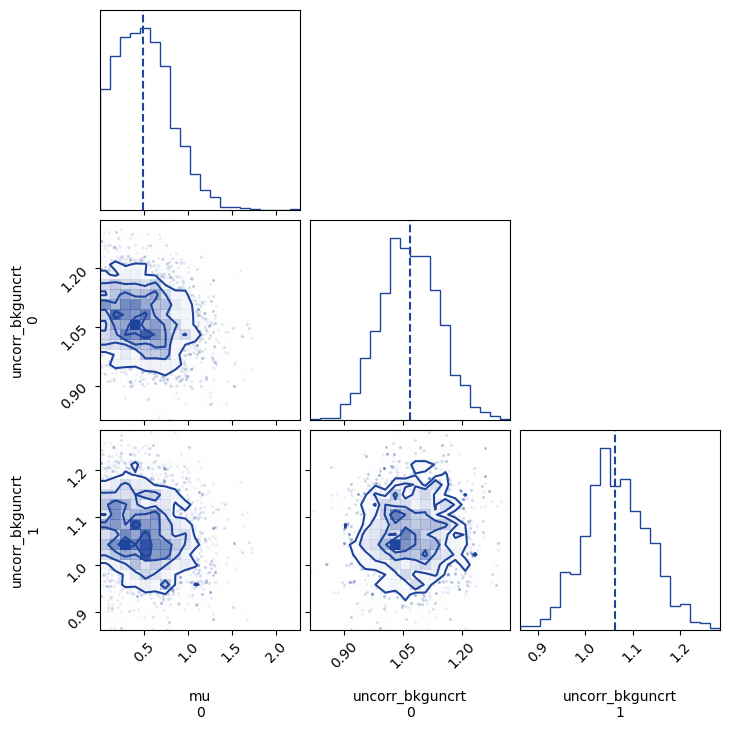

In [6]:
a = corner.corner(post_data.posterior, quantiles=[0.5], color = blue)

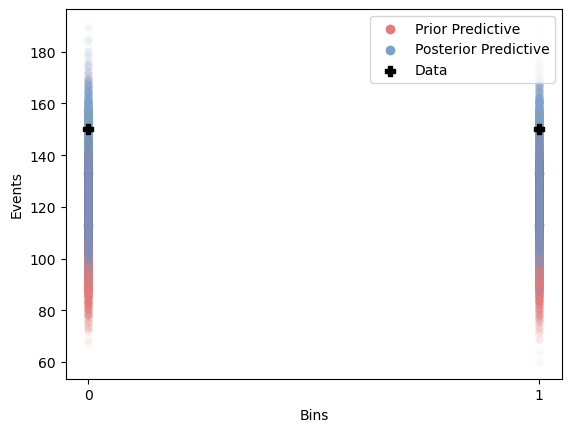

In [7]:
plotting.prior_posterior_predictives(model, data, post_pred, prior_pred, 1)